<div style="direction:rtl;line-height:300%;text-align:justify;" align="justify"><font face="B nazanin" size=4>
    <b style="font-size: 35px">Clustering</b><br>
</font></div>

# K-Means

In [1]:
import numpy as np
class KMeans:
    def __init__(self, x, k=2, max_iters=100000):
        self.max_iters = max_iters
        self.x = x
        self.k = k
        
    
    
    def centroids_update(self):
        for i in range(self.k):
            self.centroids[i] = np.mean(self.x[self.clusters == i], axis=0)
    
    
    def clusters_update(self):
            points = self.x
            centers = self.centroids
            dis = np.zeros((points.shape[0], centers.shape[0]))
            for i in range(points.shape[0]):
                for j in range(centers.shape[0]):
                    res = points[i] - centers[j]
                    dis[i, j] = np.dot(res, res)
            self.clusters = np.argmin(dis, axis=1)
            
    def distance(self):
        dis = np.zeros((self.x.shape[0], self.centroids.shape[1]))
        for n in range(self.k):
            points = self.x[self.clusters == n]
            centers = self.centroids[n]
            vector = np.zeros((points.shape[0], centers.shape[0]))
            for i in range(points.shape[0]):
                for j in range(centers.shape[0]):
                    res = points[i] - centers[j]
                    vector[i, j] = np.dot(res, res) 
            dis[:len(vector)] += vector
        return dis

    def prediction(self):
        clusters = self.clusters
        return clusters
    
    
    def fit(self):
        self.centroids = self.x[np.random.choice(self.x.shape[0], self.k, replace=False), :].copy()
        for _ in range(self.max_iters):
            self.clusters_update()
            prev_centroids = self.centroids.copy()
            self.centroids_update()
            if (prev_centroids == self.centroids).all():
                return

# GMM

In [2]:
class GMM:
    def __init__(self, x, k=2, max_iters=10000, points = None):
        self.x = x
        self.k = k
        self.max_iters = max_iters
        self.points = points
        self.m = x.shape[0]
        self.gamma = np.zeros((self.m, k))
    
     
    def params(self):
        self.pi = [1/self.k]*self.k
        if self.points is not None:
            self.mu = self.points.copy()
        else:
            self.mu = self.x[np.random.choice(self.x.shape[0], self.k, replace=False), :].copy()
        self.cov = np.tile(np.diag(np.var(self.x, axis=0)), (self.k, 1, 1))
    
    def e_step(self):
        for i in range(self.m):
            for k in range(self.k):
                num = self.x[i].size
                cov_inv = np.linalg.inv(self.cov[k])
                x_mu = (self.x[i] - self.mu[k]).reshape(-1, 1)
                gaussian_prob = np.exp(-0.5 * x_mu.T @ cov_inv @ x_mu) / np.sqrt(np.linalg.det(self.cov[k])) / (2*np.pi)**(num/2)
                self.gamma[i][k] = self.pi[k]*gaussian_prob
        self.gamma = self.gamma / self.gamma.sum(axis=1, keepdims=True)
    
    
    def m_step(self):
        Nk = self.gamma.sum(axis=0)
        self.pi = Nk / self.m
        for k in range(self.k):
            self.mu[k] = (np.sum(self.gamma[:, k:k+1]*self.x, axis=0))/Nk[k]
        
        self.cov = np.zeros_like(self.cov)
        for k in range(self.k):
            x_mu = (self.x - self.mu[k])
            for i in range(self.m):
                self.cov[k] += np.outer(x_mu[i], x_mu[i]) * self.gamma[i][k]
            self.cov[k] = self.cov[k] / Nk[k]
        
    
    def log_likelihood(self):
        vec = 0
        for i in range(self.m):
            tot = 0
            for k in range(self.k):
                num = self.x[i].size
                cov_inverse = np.linalg.inv(self.cov[k])
                x_mu = (self.x[i] - self.mu[k]).reshape(-1, 1)
                gaussian_prob = np.exp(-0.5 * x_mu.T @ cov_inverse @ x_mu) / np.sqrt(np.linalg.det(self.cov[k])) / (2*np.pi)**(num/2)
                tot += self.pi[k]*gaussian_prob
            vec += np.log(tot)
        return vec
    
    
    def fit(self):
        self.params()
        prev_likelihood = float('inf')
        for ite in range(self.max_iters):
            self.e_step()
            self.m_step()
            likelihood = self.log_likelihood()
            if np.abs(likelihood - prev_likelihood) < 0.1:
                return
            prev_likelihood = likelihood
        
        
    def predict(self):
        return np.argmax(self.gamma, axis=1)

In [4]:
from sklearn.datasets.samples_generator import make_classification
X,Y = make_classification(n_samples=700, n_features=10,
                           n_informative=5, n_redundant=0,
                           n_clusters_per_class=2, n_classes=3)

In [5]:
import matplotlib.pyplot as plt
def ploting(X, Y, kmeans_pred, gmm_pred):
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(131)
    ax.title.set_text('actual')
    ax.scatter(X[:,0], X[:,1], c=Y);
    ax = fig.add_subplot(132)
    ax.title.set_text('KMeans')
    ax.scatter(X[:,0], X[:,1], c=kmeans_pred);
    ax = fig.add_subplot(133)
    ax.title.set_text('GMM')
    ax.scatter(X[:,0], X[:,1], c=gmm_pred);

In [6]:
def kmeans_best_model(X):
    best_model = None
    min_distance = float('inf')
    for _ in range(200):
        model = KMeans(X, k=2)
        model.fit()
        distance = model.distance()
        if (distance < min_distance).all():
            best_model = model
            min_distance = distance
    return best_model

In [7]:
kmeans_best = kmeans_best_model(X)
kmeans_pred = kmeans_best.prediction()

In [8]:
points = kmeans_best.centroids
gmm = GMM(X, k=2 ,points= points)
gmm.fit()
gmm_pred = gmm.predict()

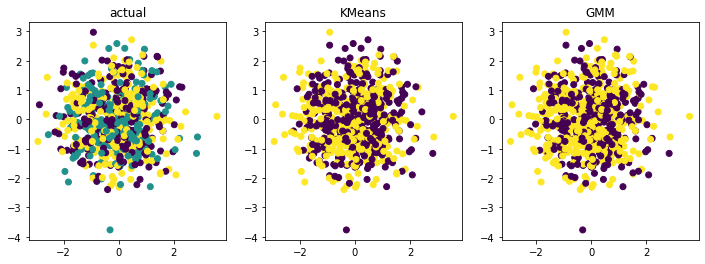

In [9]:
ploting(X, Y, kmeans_pred, gmm_pred)

In [10]:
from scipy.special import comb
def purity(y_real, y_pred):
    purity = 0  
    y = sorted(set(y_pred))
    match = 0
    for k in y:
        ids = [i for i, j in enumerate(y_pred) if j == k]
        cluster = [y_real[i] for i in ids]
        d={}
        for l in cluster:
            if l in d :
                d[l] += 1
            else: d[l] = 1
        match += max(d.values())
    purity =  match / float(len(y_real))
    return purity 

def rand_index(y_true, y_pred):
    true_pos_false_pos = comb(np.bincount(y_true), 2).sum()
    true_pos_false_neg = comb(np.bincount(y_pred), 2).sum()
    A = np.c_[(y_true, y_pred)]
    true_pos = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(y_true))
    false_pos = true_pos_false_pos - true_pos
    false_neg = true_pos_false_neg - true_pos
    true_neg = comb(len(A), 2) - true_pos - false_pos - false_neg
    return (true_pos + true_neg) / (true_pos + false_pos + false_neg + true_neg)

In [11]:
print('Purity','Kmeans:',purity(Y,kmeans_pred),",GMM:",purity(Y,gmm_pred))
print('RandIndex','Kmeans:',rand_index(Y,kmeans_pred),",GMM:",rand_index(Y,gmm_pred))

Purity Kmeans: 0.37714285714285717 ,GMM: 0.37285714285714283
RandIndex Kmeans: 0.5039975475168608 ,GMM: 0.49977927651747395


As can be seen from the purity and randindex for this dataset,the KMeans metod has performed better GMM, although this dataset consists of three categories.The purity and randIndex of kmeans metod is more than GMM.

In [12]:
from sklearn.datasets.samples_generator import make_classification
X1, Y1 = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

In [13]:
kmeans_best1 = kmeans_best_model(X1)
kmeans_pred1 = kmeans_best1.prediction()

In [14]:
points1 = kmeans_best1.centroids
gmm1 = GMM(X1, k=2 ,points= points1)
gmm1.fit()
gmm_pred1 = gmm1.predict()

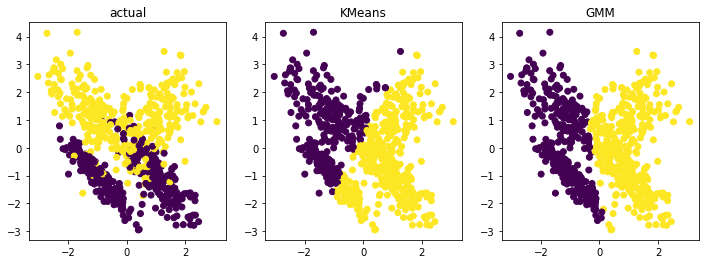

In [15]:
ploting(X1, Y1, kmeans_pred1, gmm_pred1)

In [16]:
print('Purity','Kmeans:',purity(Y1,kmeans_pred1),",GMM:",purity(Y1,gmm_pred1))
print('RandIndex','Kmeans:',rand_index(Y1,kmeans_pred1),",GMM:",rand_index(Y1,gmm_pred1))

Purity Kmeans: 0.5914285714285714 ,GMM: 0.5242857142857142
RandIndex Kmeans: 0.516026977314531 ,GMM: 0.5004659717964439


Kmeans method We observe that the denser samples of the mass and the left protrusion are together in one cluster and parts of the other protrusions are in the second cluster.But the GMM we see has a protrusion completely in a cluster, which shows that it has a good understanding of the data structure, seem to be a good classification and have identified a logical cluster.

In [17]:
from sklearn.datasets.samples_generator import make_moons
X2, Y2 = make_moons(n_samples=700, noise=0.2)

In [18]:
kmeans_best2 = kmeans_best_model(X2)
kmeans_pred2 = kmeans_best2.prediction()

In [19]:
points2 = kmeans_best2.centroids
gmm2 = GMM(X2, k=2 ,points= points2)
gmm2.fit()
gmm_pred2 = gmm2.predict()

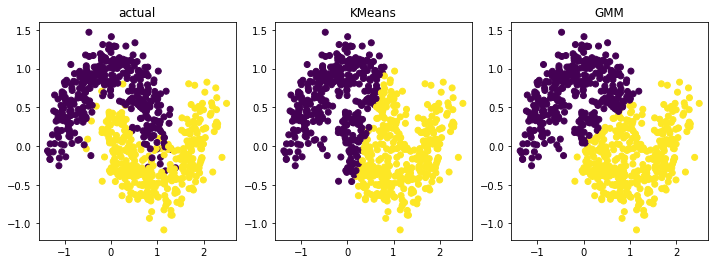

In [20]:
ploting(X2, Y2, kmeans_pred2, gmm_pred2)

In [21]:
print('Purity','Kmeans:',purity(Y2,kmeans_pred2),",GMM:",purity(Y2,gmm_pred2))
print('RandIndex','Kmeans:',rand_index(Y2,kmeans_pred2),",GMM:",rand_index(Y2,gmm_pred2))

Purity Kmeans: 0.7614285714285715 ,GMM: 0.8542857142857143
RandIndex Kmeans: 0.636170038830983 ,GMM: 0.750680564071122


The graphs of the two clusters are very close to each other, so according to the randindex and the purity, it can be said that GMM has identified the clusters much better than the kmeans.

In [22]:
from sklearn.datasets.samples_generator import make_circles
X3, Y3 = make_circles(n_samples=700, noise=0.2)

In [23]:
kmeans_best3 = kmeans_best_model(X3)
kmeans_pred3 = kmeans_best3.prediction()

In [24]:
points3 = kmeans_best3.centroids
gmm3 = GMM(X3, k=2 ,points= points3)
gmm3.fit()
gmm_pred3 = gmm3.predict()

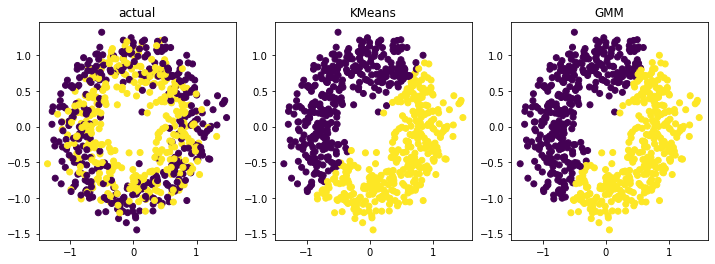

In [25]:
ploting(X3, Y3, kmeans_pred3, gmm_pred3)

In [26]:
print('Purity','Kmeans:',purity(Y3,kmeans_pred3),",GMM:",purity(Y3,gmm_pred3))
print('RandIndex','Kmeans:',rand_index(Y3,kmeans_pred3),",GMM:",rand_index(Y3,gmm_pred3))

Purity Kmeans: 0.5128571428571429 ,GMM: 0.5071428571428571
RandIndex Kmeans: 0.4996157776415287 ,GMM: 0.4993868792152054


In this dataset, two regions of the ring are created, the inner ring belongs to one category and the outer ring belongs to the other category. But the kmeans and GMM methods find two regions that are relatively linearly separated from each other.and the purity and rand index of both method is almost half.